## Import TensorFlow and other libraries

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
# !tensorboard --bind_all --logdir=my_log_dir

In [2]:
# Importing the library
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 16.1
RAM Used (GB): 18.200383488


In [3]:
import datetime
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.chdir('/home/royhersh/train_gaf')

2023-08-05 10:00:43.982339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 10:00:46.802282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [4]:
from preprocessing.features_extractors.raw_extractor import RawExtractor
from preprocessing.data_translator.gaf_translator import GafTranslator
from preprocessing.preprocessor import Preprocessor

SAMPLE_LENGTH_SECONDS = 2
WINDOWS = 4
BATCH_SIZE = 100
EVALUATION_BATCH_SIZE = 4000
RESAMPLE_MS = SAMPLE_LENGTH_SECONDS * 1000 // WINDOWS
DATAPOINTS_PER_SECOND = 60
DATA_PATH = "/sise/yos-group/royhersh"
PATH = f"{DATA_PATH}/data/processed/fixed_{DATAPOINTS_PER_SECOND}"
ANOMALIES_PATH = f"{DATA_PATH}/anomalies/processed/fixed_{DATAPOINTS_PER_SECOND}"
AXIS_WINDOWS_AMOUNT = SAMPLE_LENGTH_SECONDS * DATAPOINTS_PER_SECOND  # 4 windows * 0.500 s/window * 60 points-in-sample/s = 120 points-in-sample
INPUT_SHAPE = (AXIS_WINDOWS_AMOUNT, AXIS_WINDOWS_AMOUNT)
# AXES = ['tot']
# AXES = ['x', 'y', 'z']
AXES = ['x', 'y', 'z', 'tot']

extractor = RawExtractor(resample_amount=RESAMPLE_MS)
preprocess = Preprocessor(extractor, translators=[GafTranslator(AXIS_WINDOWS_AMOUNT, WINDOWS)], packed_windows=WINDOWS,
                          path=PATH)
anomalies_preprocess = Preprocessor(extractor, translators=[GafTranslator(AXIS_WINDOWS_AMOUNT, WINDOWS)],
                                    packed_windows=WINDOWS, path=ANOMALIES_PATH)

In [5]:
OUTPUT_FILE = 'models/gaf_autoencoders/{extractor}/{time}/'.format(
    extractor=str(extractor),
    time=datetime.datetime.now().strftime("%y.%m.%d/%H.%M")) + '/{file_name}.{file_type}'
FILE_TYPE = 'h5'
print(OUTPUT_FILE)

models/gaf_autoencoders/RawExtractor/23.08.05/10.00//{file_name}.{file_type}


In [6]:
from gaf_dataset_loader import GAFDatasetLoader

sensor = 'gyroscope'
translator = GafTranslator(AXIS_WINDOWS_AMOUNT, WINDOWS, method='summation')
# translator = GafTranslator(AXIS_WINDOWS_AMOUNT, WINDOWS, method='difference')
train_dataset = GAFDatasetLoader(preprocess.get_file_name(sensor, [translator]), AXES, batch_size=BATCH_SIZE)
anomaly_dataset = GAFDatasetLoader(anomalies_preprocess.get_file_name(sensor, [translator]), AXES,
                                   batch_size=BATCH_SIZE)

Plot a normal sample. 

In [7]:
FIG_SIZE = 4

def simple_plot(title, data):
    data = np.array(data).reshape(INPUT_SHAPE)
    plt.clf()
    fig = plt.figure()
    plt.pcolor(np.arange(0, AXIS_WINDOWS_AMOUNT, 1.), np.arange(0, AXIS_WINDOWS_AMOUNT, 1.), data, cmap='rainbow', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

def simple_subplot(title, data, subplot_data):
    data = np.array(data).reshape(INPUT_SHAPE)
    plt.subplot(*subplot_data)
    plt.pcolor(np.arange(0, AXIS_WINDOWS_AMOUNT, 1.), np.arange(0, AXIS_WINDOWS_AMOUNT, 1.), data, cmap='rainbow', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()

def plot_groups(title_format, data):
    fig_width = FIG_SIZE + 2
    for i in range(min(3, len(data))):
        plt.figure(figsize=(len(AXES)*fig_width, FIG_SIZE))
        for axis in range(len(AXES)):
            simple_subplot(title_format.format(sensor=sensor, i=i, axis=AXES[axis]), data[i][axis], (1, 4, axis+1))
        plt.show()
        
def draw_data(title_format, dataset):
    dataset._batch_size = 3
    plot_groups(title_format, dataset[0])

2023-08-05 10:00:57.221491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10377 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


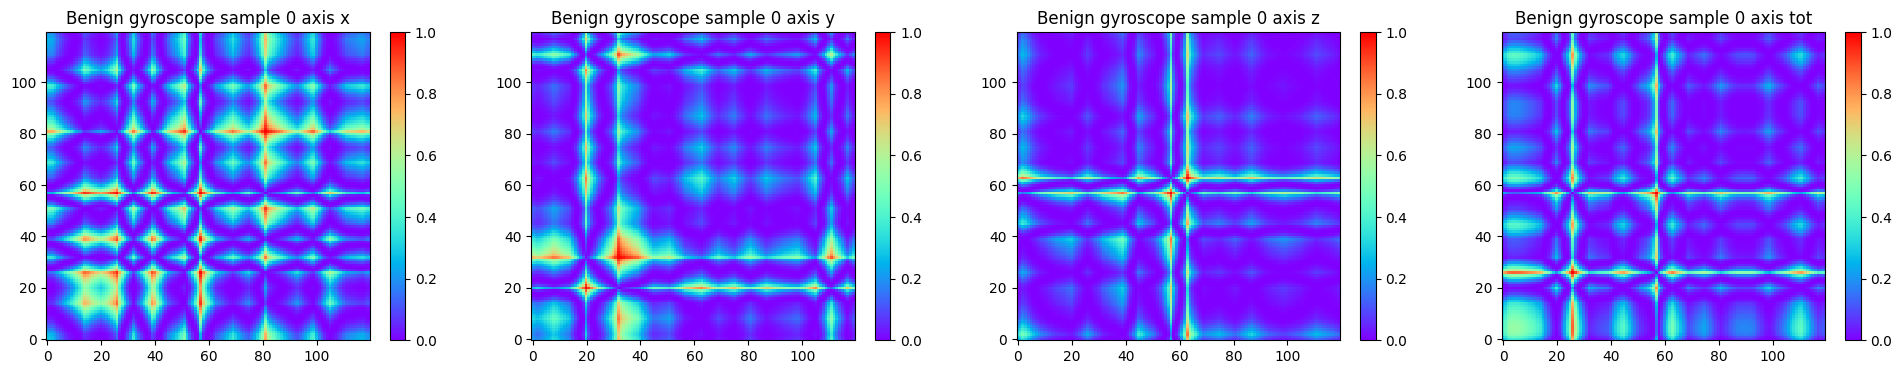

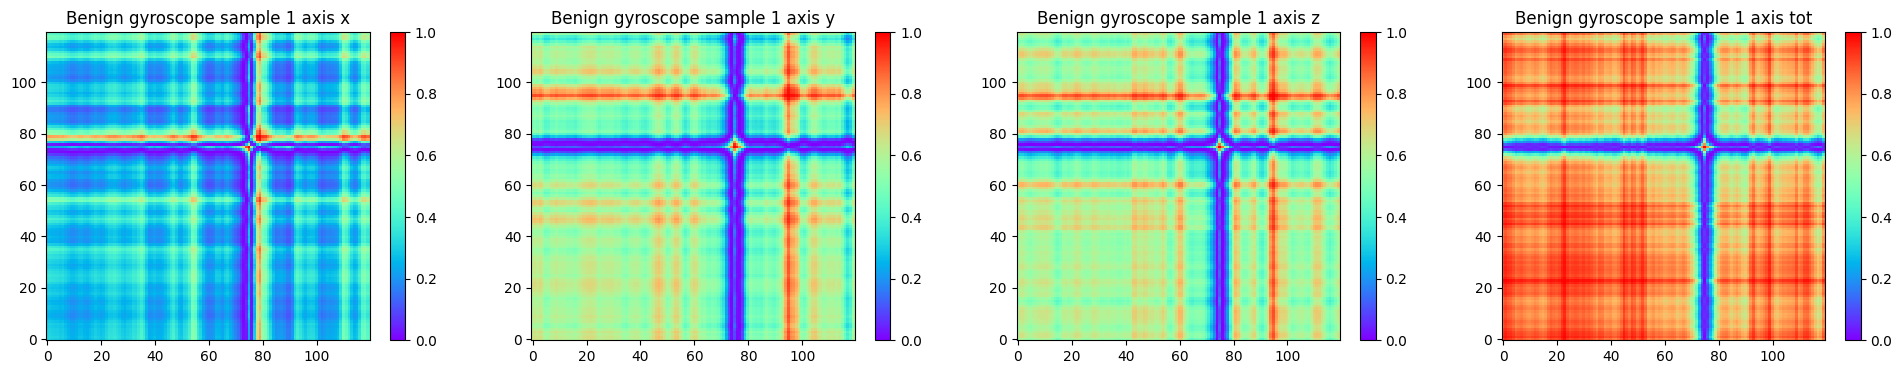

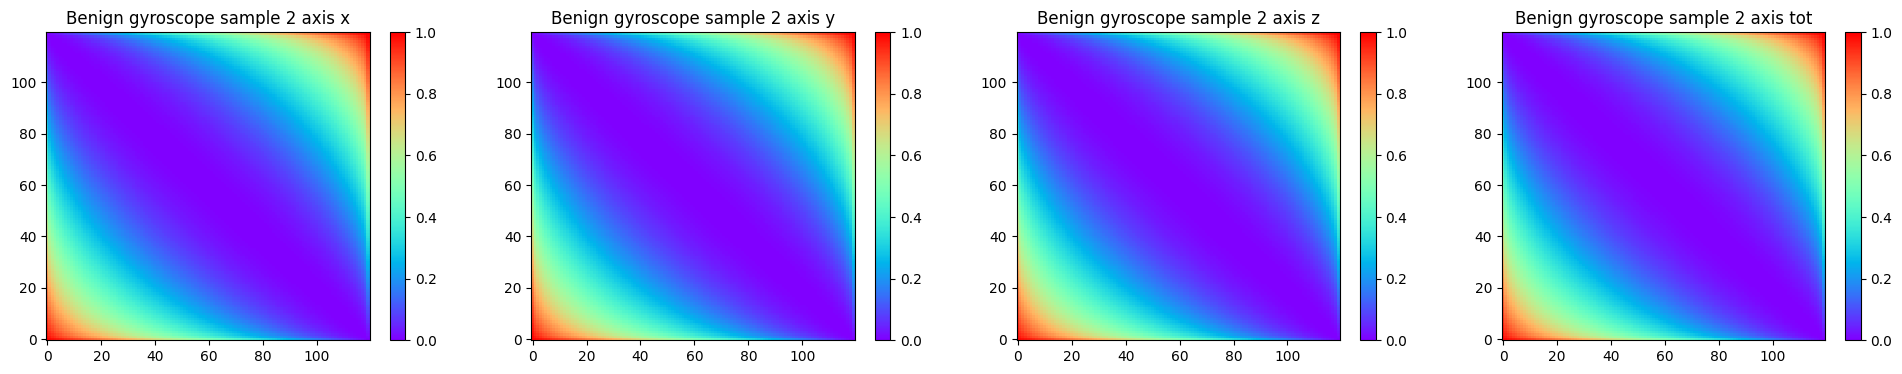

In [8]:
draw_data("Benign {sensor} sample {i} axis {axis}", train_dataset.get_train())

Plot an anomalous samples.

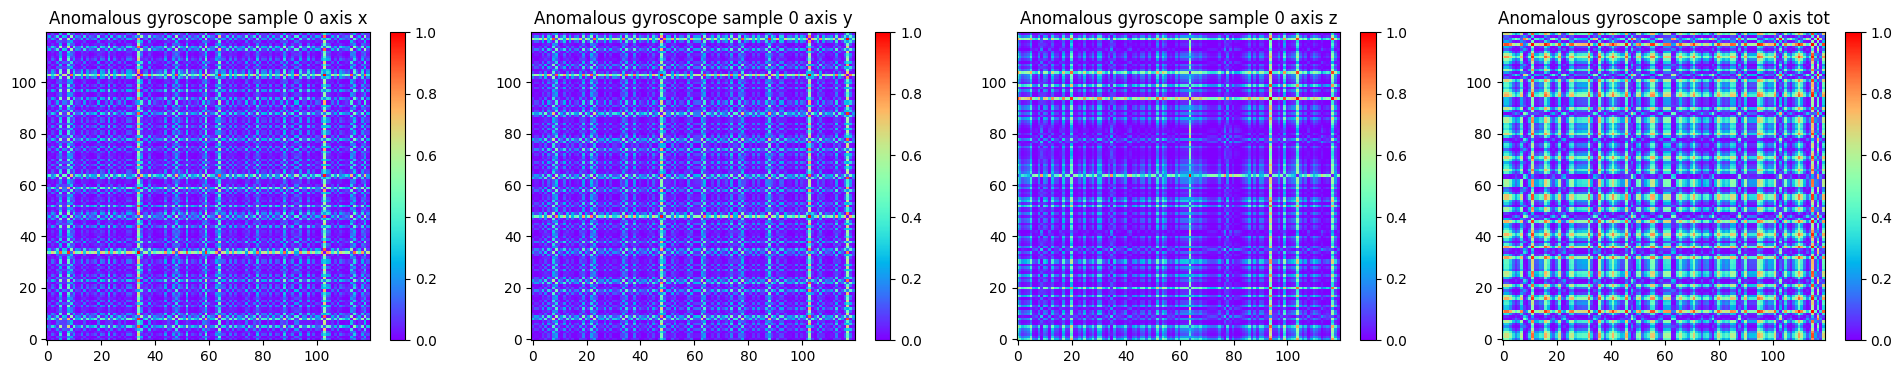

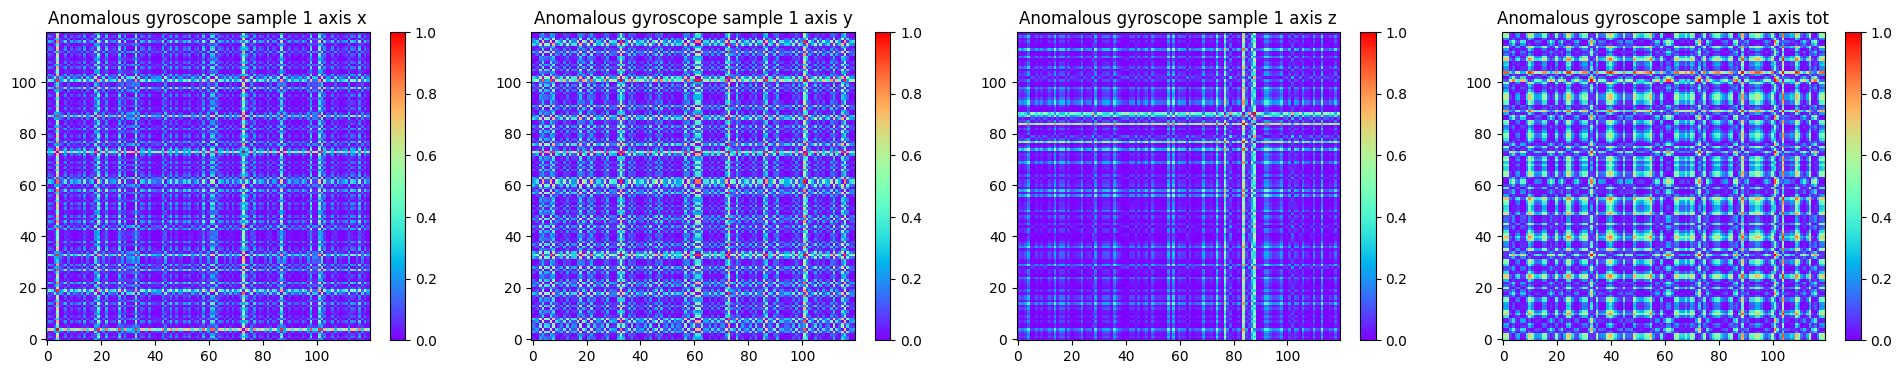

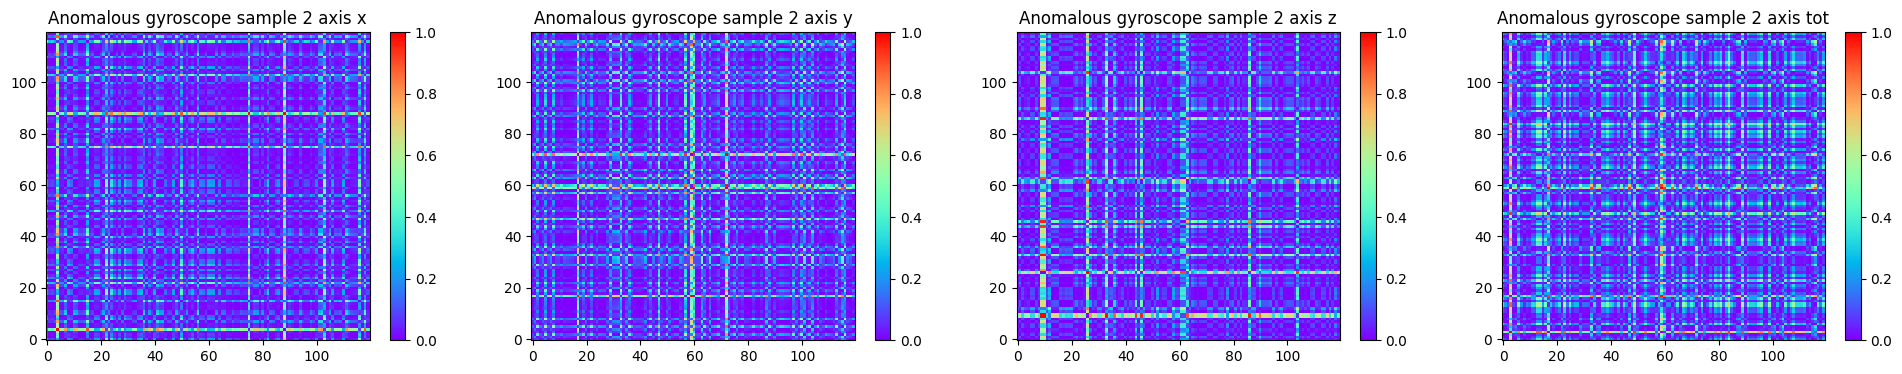

In [9]:
draw_data("Anomalous {sensor} sample {i} axis {axis}", anomaly_dataset.get_train())

### Build the model

In [10]:
class AnomalyDetector(Model):
    ENCODED_SIZE = 300

    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(*INPUT_SHAPE,1), batch_size=BATCH_SIZE, dtype=tf.dtypes.float32),
            layers.Conv2D(filters=1, kernel_size=(5,5), strides=(2,2), activation='relu'),
            layers.Flatten(),
            layers.Dense(1800, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(self.ENCODED_SIZE, activation="relu")
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(1800, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(3600, activation='relu'), # manual adapt to INPUT_SHAPE
            layers.Reshape((60, 60, 1)),
            layers.Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
            layers.Reshape(INPUT_SHAPE, dtype=tf.dtypes.float32)
        ])

    def call(self, x):
        # x = tf.expand_dims(x, axis=-1)
        return self.decoder(self.encoder(x))

    def save_model(self, file_name: str, extra_detail: str = ""):
        print(f"Saving model {self} to {OUTPUT_FILE.format(file_name=f'{file_name}*', file_type=FILE_TYPE)}")
        self.encoder.save(OUTPUT_FILE.format(file_name=f"{file_name}_encoder{extra_detail}", file_type=FILE_TYPE), save_format=FILE_TYPE)
        self.decoder.save(OUTPUT_FILE.format(file_name=f"{file_name}_decoder{extra_detail}", file_type=FILE_TYPE), save_format=FILE_TYPE)
    
    def load_model(self, file_name: str, extra_detail: str = ""):
        print(f"Loading model from {OUTPUT_FILE.format(file_name=f'{file_name}*', file_type=FILE_TYPE)}")
        self.encoder = tf.keras.models.load_model(OUTPUT_FILE.format(file_name=f"{file_name}_encoder{extra_detail}", file_type=FILE_TYPE))
        self.decoder = tf.keras.models.load_model(OUTPUT_FILE.format(file_name=f"{file_name}_decoder{extra_detail}", file_type=FILE_TYPE))


In [11]:
class AnomalyDetectors():
    def __init__(self, dataset, axes=AXES):
        self.new_model = True
        self._dataset = dataset
        self._axes = axes
        self._auto_encoders_amount = len(axes)
        self._start_index = 0
        self._auto_encoders = [AnomalyDetector() for _ in self.get_axis_range()]
        for axis_autoencoder in self._auto_encoders:
            axis_autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
            # axis_autoencoder.compile(optimizer='adam', loss=CustomAccuracy(), metrics=['mae', 'mse'])

    def encoder(self, samples):
        output = []
        for index in self.get_axis_range():
            samples_axis = np.asarray([data[index] for data in samples], dtype=np.float32)
            output.append(self._auto_encoders[index].encoder(samples_axis).numpy())
        return list(zip(*output))

    def decoder(self, encoded_samples: np.ndarray) -> np.ndarray:
        output = []
        for index in self.get_axis_range():
            encoded_samples_axis = np.asarray([data[index] for data in encoded_samples], dtype=np.float32)
            output.append(self._auto_encoders[index].decoder(encoded_samples_axis).numpy())
        return list(zip(*output))

    def get_axis_range(self):
        return range(self._start_index, self._auto_encoders_amount)

    def call(self, samples):
        output = []
        for index in self.get_axis_range():
            samples_axis = np.asarray([data[index] for data in samples], dtype=np.float32)
            output.append(self._auto_encoders[index].call(samples_axis).numpy())
        return list(zip(*output))

    def train(self, epochs=50):
        histories = [[] for _ in self.get_axis_range()]
        train_data = self._dataset.get_train()
        test_data = self._dataset.get_test()
        length_train = len(train_data)
        length_test = len(test_data)
        print(f"Training data {length_train}")
        print(f"Test data {length_test}")
        for epoch in range(epochs):
            print(f"Starting epoch {epoch}")
            for batch_index in range(length_train):
                print(f"train_load {epoch}-{batch_index}/{length_train}")
                current_train = train_data[batch_index]
                batch_loss = []
                for axis in self.get_axis_range():
                    train_cur = np.asarray([data[axis] for data in current_train], dtype=np.float32)
                    assert len(train_cur) == BATCH_SIZE, f"[x] No train data on {batch_index}-{axis} - {len(train_cur)}!={BATCH_SIZE} - {np.array(current_train).shape} {train_cur.shape}"
                    loss = self._auto_encoders[axis].train_on_batch(train_cur, train_cur)
                    batch_loss.append(loss)
                    histories[axis].append(loss)
                print(f"Batch round loss {','.join(map(str, batch_loss))}")
            train_data.on_epoch_end()
        return histories

    def save_model(self, file_name: str):
        for index, axis in enumerate(self._axes):
            self._auto_encoders[index].save_model(file_name, axis)
    
    def load_model(self, file_name: str):
        self.new_model = False
        for index, axis in enumerate(self._axes):
            self._auto_encoders[index].load_model(file_name, axis)

In [12]:
autoencoder = AnomalyDetectors(train_dataset)

In [13]:
def get_model_file_name():
    return f"{sensor}_{extractor._ms_resample}x{preprocess._packed_windows}_{INPUT_SHAPE}_{AnomalyDetector.ENCODED_SIZE}"
    
def load_model(model_date: str):
    global OUTPUT_FILE
    OUTPUT_FILE = 'models/gaf_autoencoders/{extractor}/{time}'.format(extractor=str(extractor), time=model_date) + '/{file_name}.{file_type}'
    autoencoder.load_model(get_model_file_name())

    
def save_model():
    os.makedirs(pathlib.Path(OUTPUT_FILE).parent, exist_ok=True)
    autoencoder.save_model(get_model_file_name())

# load_model("11.06.23/23.02")

Notice that the autoencoder is trained using only the normal samples, but is evaluated using the full test set.

In [ ]:
histories = autoencoder.train(epochs=30)

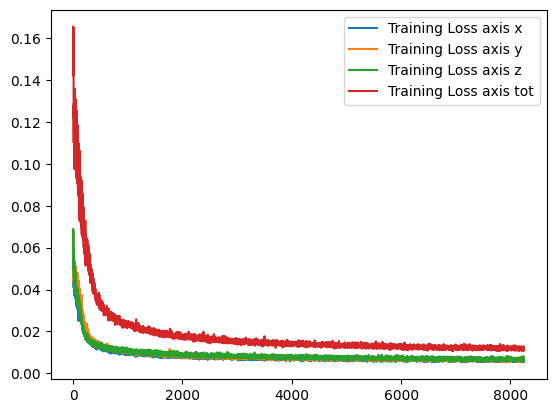

In [15]:
for index in range(len(histories)):
    plt.plot(histories[index], label=f"Training Loss axis {AXES[index]}")
    plt.legend()

You will soon classify an samples as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal samples from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [16]:
# EVALUATION_BATCH_SIZE = BATCH_SIZE
TRAIN_DATASET = train_dataset.get_train()
TRAIN_DATASET._batch_size = EVALUATION_BATCH_SIZE
TEST_DATASET = train_dataset.get_test()
TEST_DATASET._batch_size = EVALUATION_BATCH_SIZE
print(f"Loading train_batch {EVALUATION_BATCH_SIZE}")
train_batch = TRAIN_DATASET[0]
print(f"Loading test_batch {EVALUATION_BATCH_SIZE}")
test_batch = TEST_DATASET[0]

Loading train_batch 4000
Loading test_batch 4000


In [17]:
FIG_SIZE = 9

def plot_decoded_original(title, test_data, decoded_data):
    simple_plot(f"Input {title}", test_data)
    simple_plot(f"Reconstructed {title}", decoded_data)


def plot_original_vs_reconstructed(title_format, reconstructed_title_format, data, reconstructed_data):
    fig_width = FIG_SIZE - 3
    for i in range(min(3, len(data))):
        plt.figure(figsize=(len(AXES)*fig_width, FIG_SIZE))
        for axis in range(len(AXES)):
            simple_subplot(title_format.format(sensor=sensor, i=i, axis=AXES[axis]), data[i][axis], (2, len(AXES), axis+1))
        for axis in range(len(AXES)):
            simple_subplot(reconstructed_title_format.format(sensor=sensor, i=i, axis=AXES[axis]), reconstructed_data[i][axis], (2, len(AXES), axis+1+len(AXES)))
        plt.show()

In [18]:
def encode_decode_plot(autoencoder, data_batch, title_format, reconstructed_title_format):
    print(f"Encode {len(data_batch)}")
    encoded_data = autoencoder.encoder(data_batch)
    print(f"Decode {len(encoded_data)}")
    decoded_data = autoencoder.decoder(encoded_data)
    print(np.array(test_batch).shape, np.array(encoded_data).shape, np.array(decoded_data).shape)
    plot_original_vs_reconstructed(title_format, reconstructed_title_format, test_batch, decoded_data)

Encode 3
Decode 3
(4000, 4, 120, 120) (3, 4, 300) (3, 4, 120, 120)


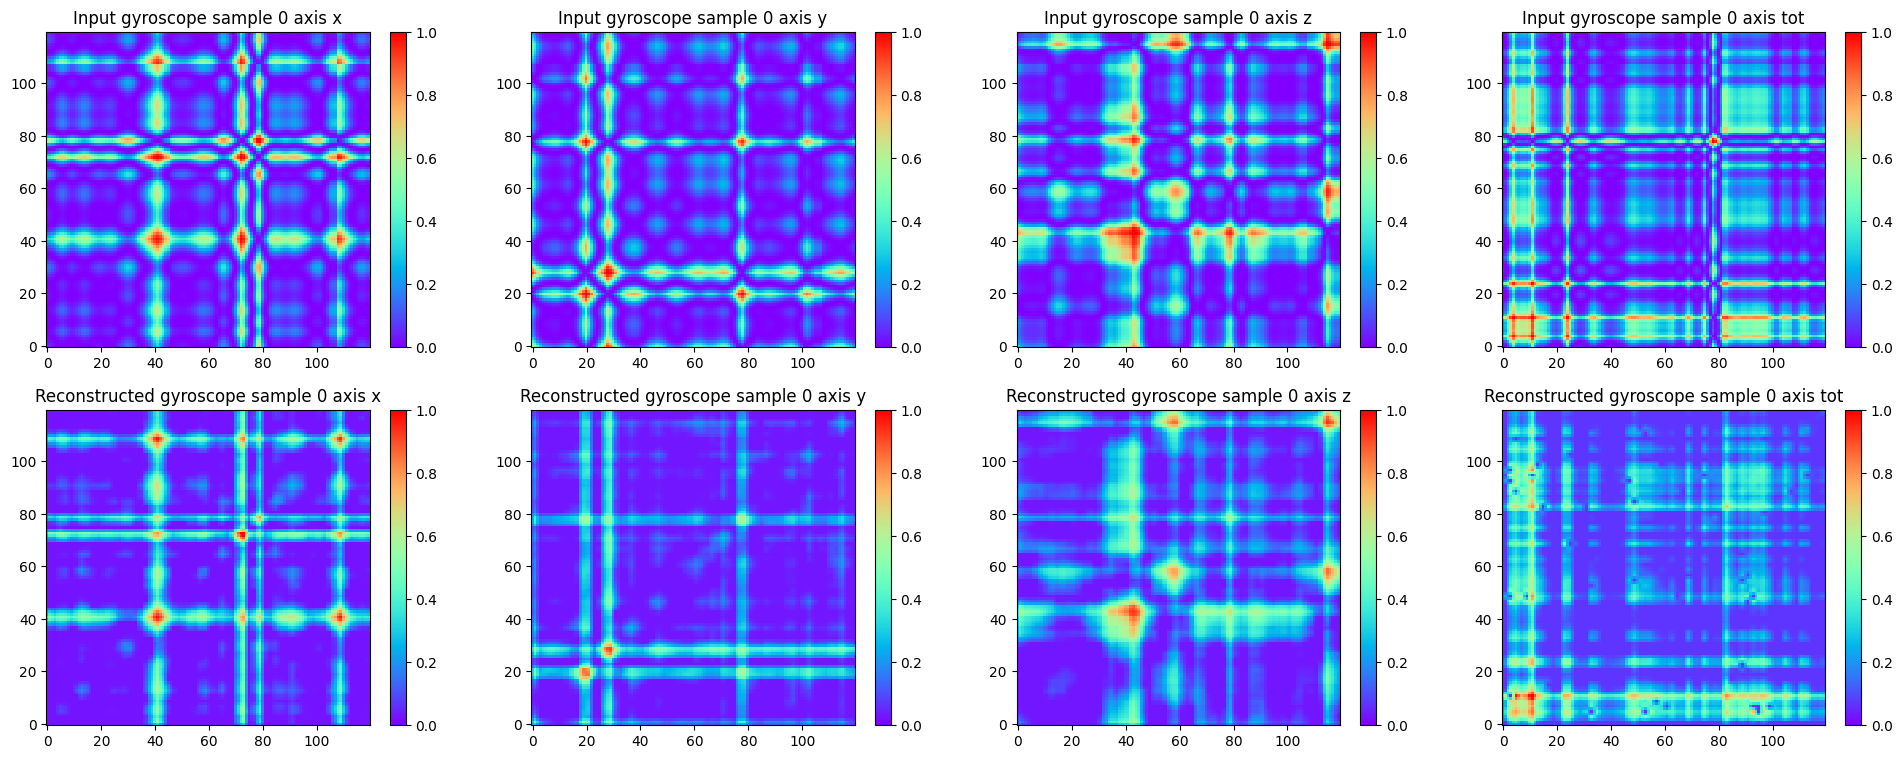

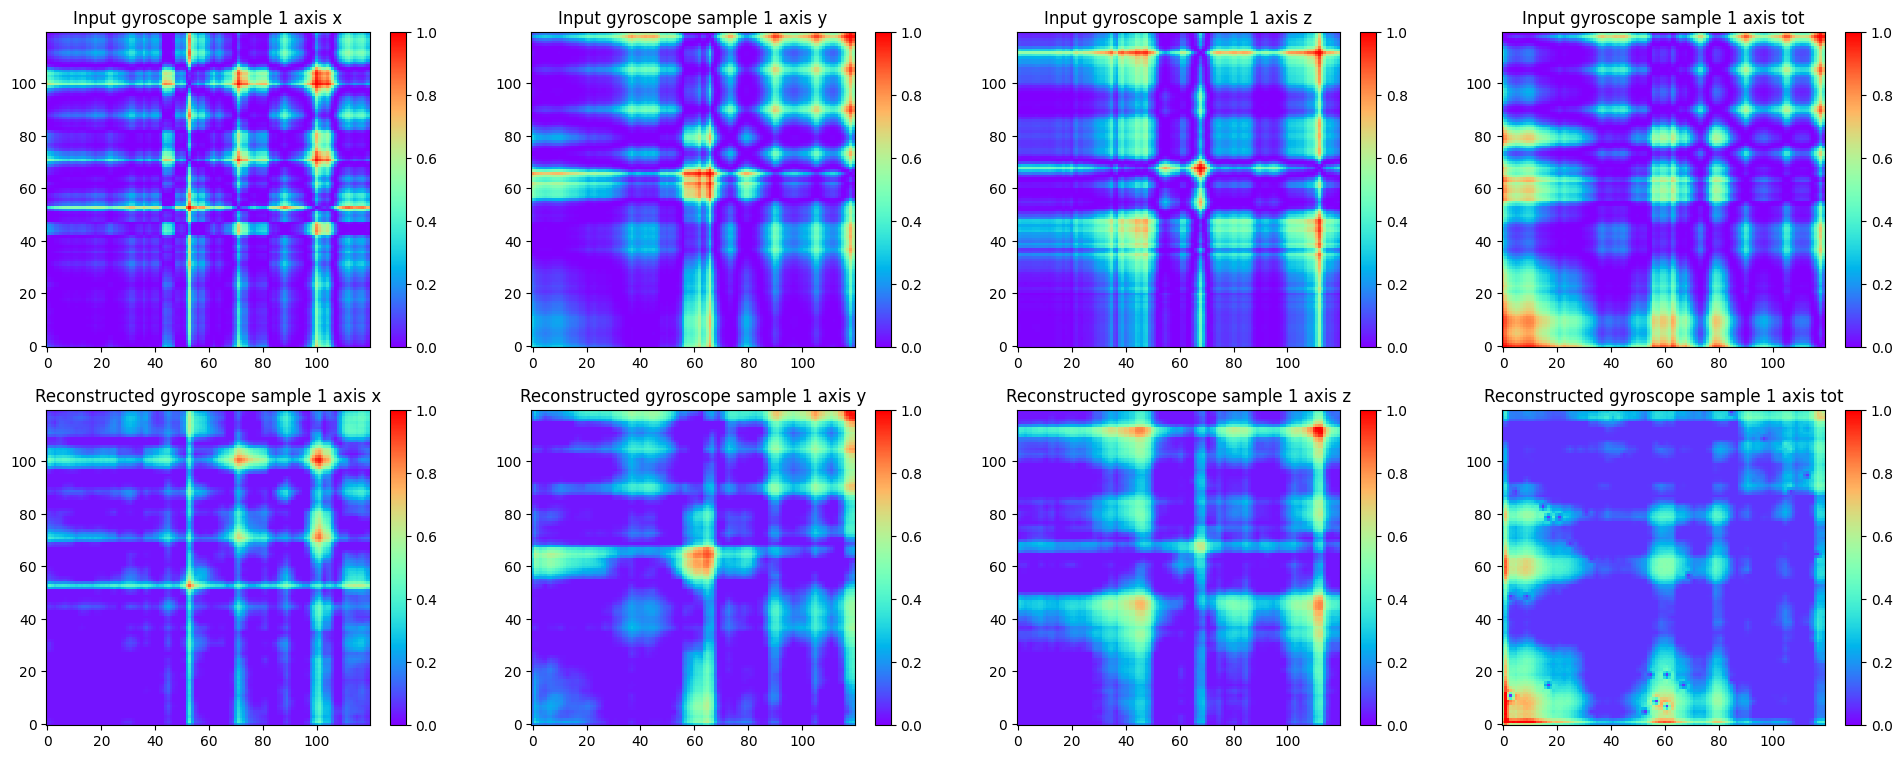

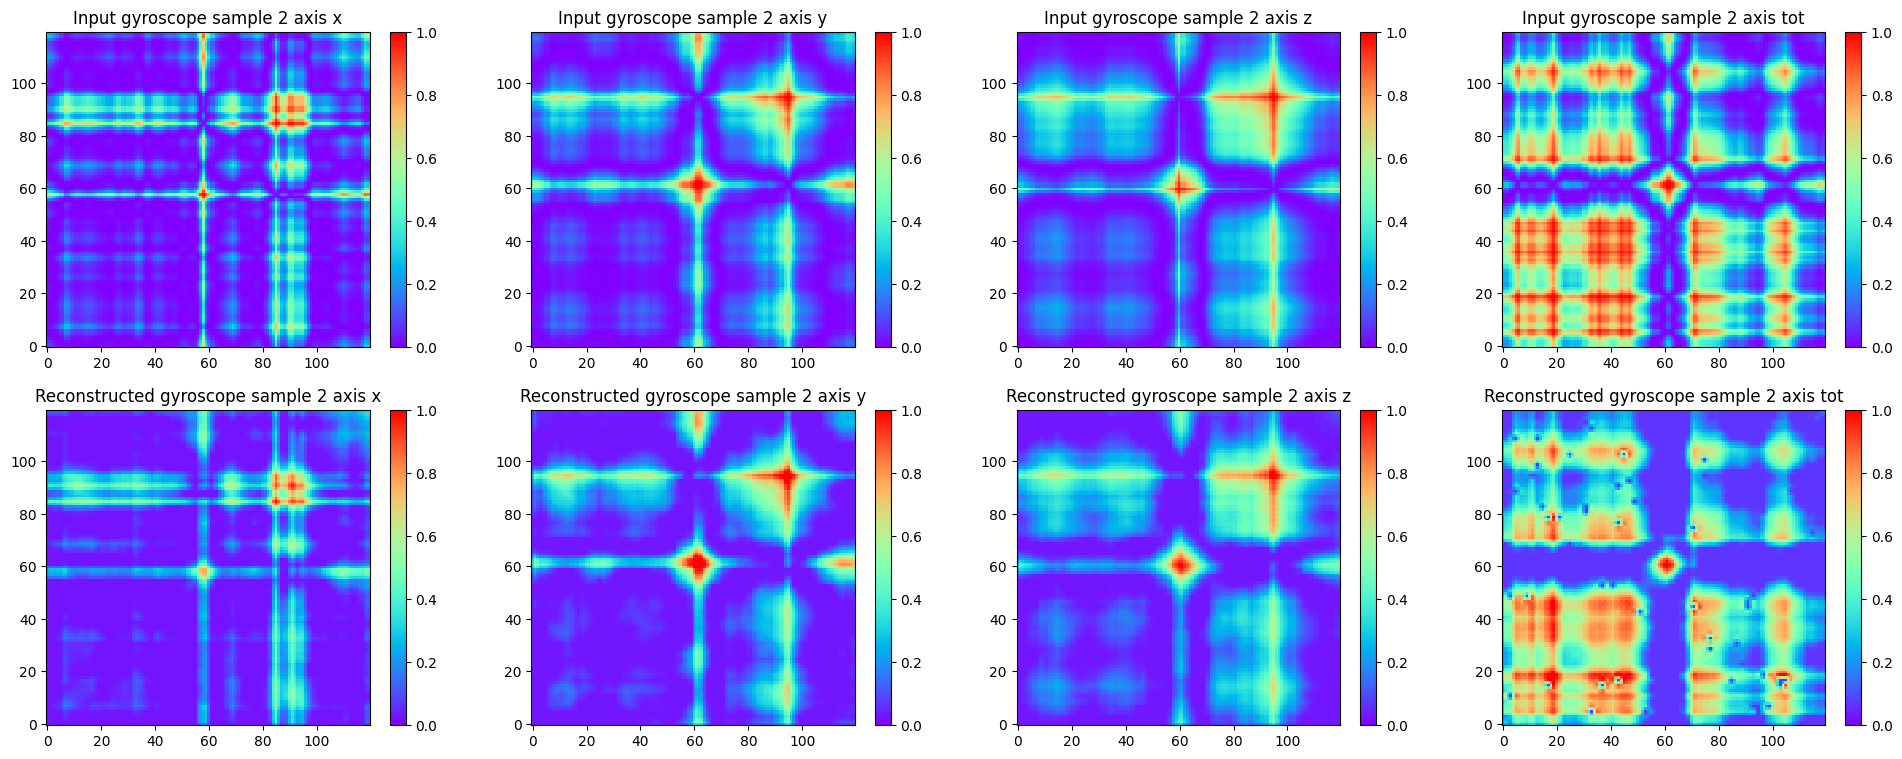

In [19]:
encode_decode_plot(autoencoder, test_batch[0:3], "Input {sensor} sample {i} axis {axis}", "Reconstructed {sensor} sample {i} axis {axis}")

Create a similar plot, this time for an anomalous test example.

In [20]:
ANOMALY_TRAIN_DATASET = anomaly_dataset.get_train()
ANOMALY_TRAIN_DATASET._batch_size = EVALUATION_BATCH_SIZE
ANOMALY_TEST_DATASET = anomaly_dataset.get_test()
ANOMALY_TEST_DATASET._batch_size = EVALUATION_BATCH_SIZE
print(f"Loading anomaly_train_batch {EVALUATION_BATCH_SIZE}")
anomaly_train_batch = ANOMALY_TRAIN_DATASET[0]
print(f"Loading anomaly_test_batch {EVALUATION_BATCH_SIZE}")
anomaly_test_batch = ANOMALY_TEST_DATASET[0]

Loading anomaly_train_batch 4000
[-] Error loading 0-4000, loaded 3367/4000
Loading anomaly_test_batch 4000
[-] Error loading 0-4000, loaded 1443/4000


Encode 3
Decode 3
(4000, 4, 120, 120) (3, 4, 300) (3, 4, 120, 120)


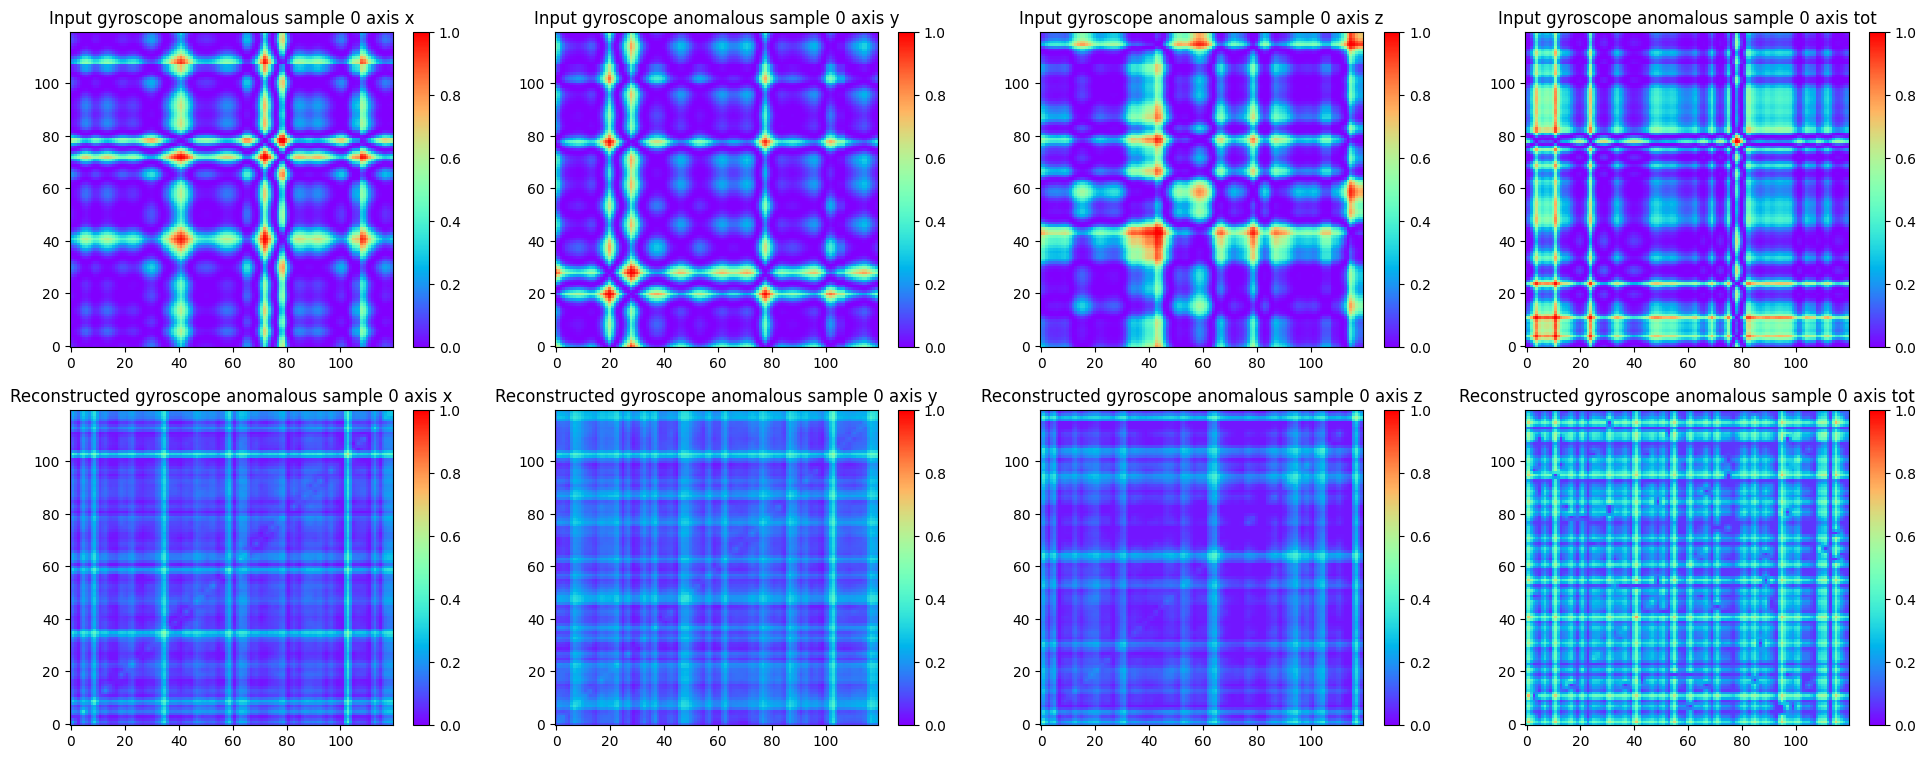

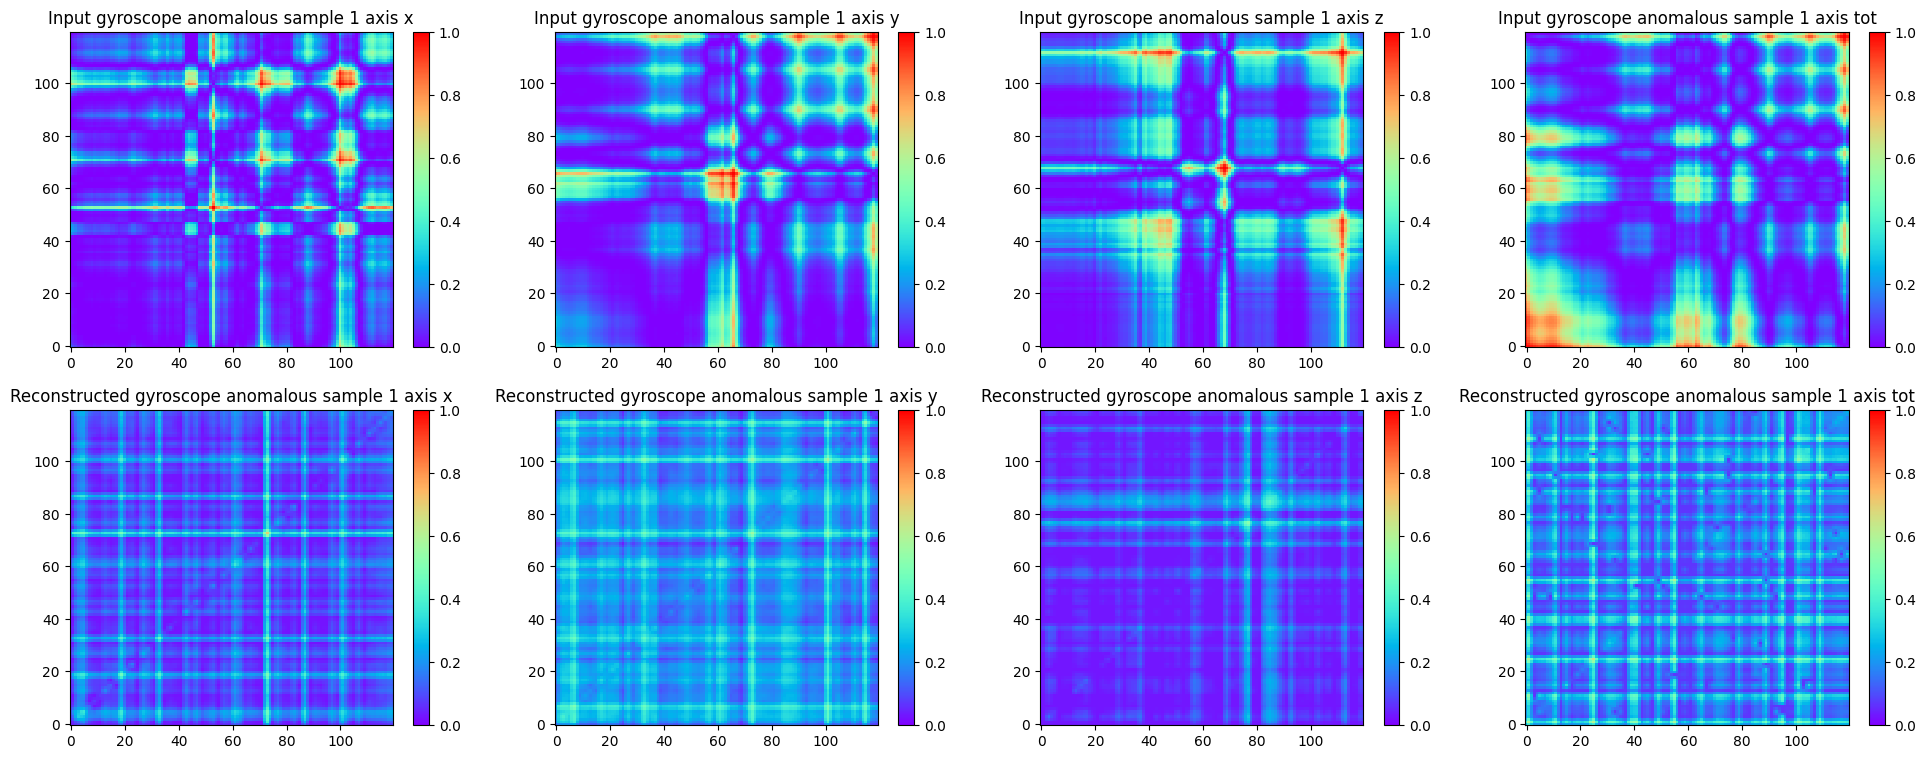

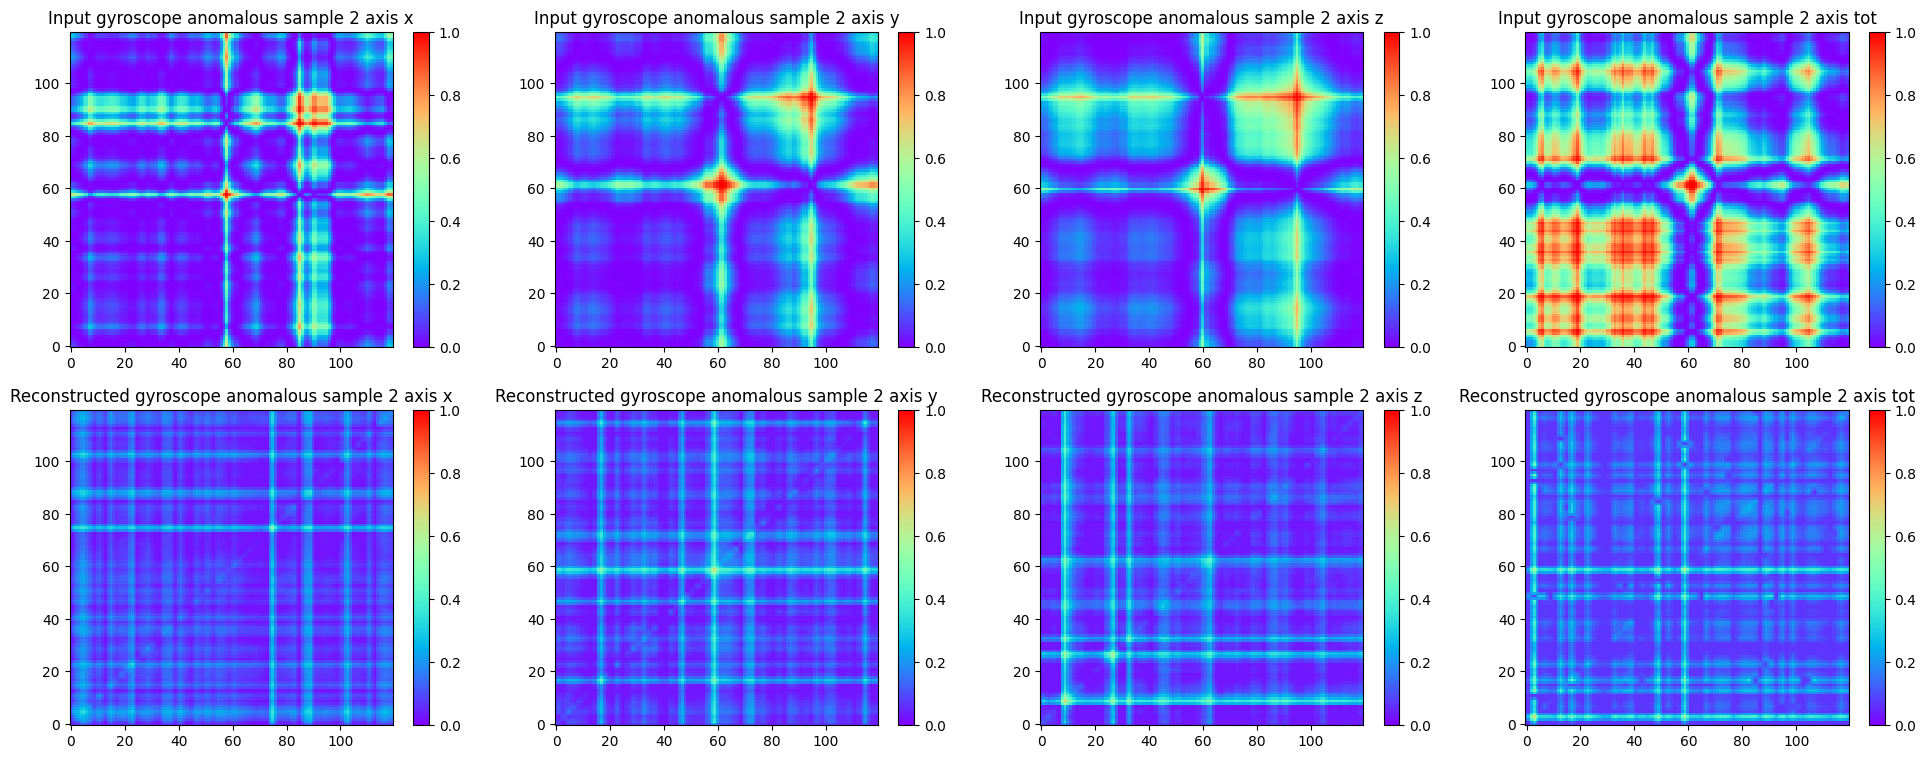

In [21]:
encode_decode_plot(autoencoder, anomaly_train_batch[0:3], "Input {sensor} anomalous sample {i} axis {axis}", "Reconstructed {sensor} anomalous sample {i} axis {axis}")

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal samples from the training set

In [22]:
LOSS_ARRANGE_SIZE = AXIS_WINDOWS_AMOUNT * AXIS_WINDOWS_AMOUNT


def calculate_loss(model, data):
    print(data.shape)
    reconstructions = model.call(data)
    print(np.array(reconstructions).shape)
    # custom_acc = CustomAccuracy()
    custom_acc = tf.keras.losses.MeanSquaredError()
    amount, axes, _data1, _data2 = data.shape
    loss = []
    for i in range(amount):
        tmp_loss = 0
        for axis in model.get_axis_range():
            tmp_loss += custom_acc.call(np.array(reconstructions[i][axis-model._start_index]).reshape(LOSS_ARRANGE_SIZE),
                                        np.array(data[i][axis]).reshape(LOSS_ARRANGE_SIZE))
        loss.append(tmp_loss)
    return loss

In [23]:
np.array(train_batch).shape

(4000, 4, 120, 120)

In [24]:
def calculate_loss_span(autoencoder, data_batch, title = ""):
    train_loss = calculate_loss(autoencoder, data_batch)
    loss_mean = np.mean(train_loss)
    loss_std = np.std(train_loss)
    plt.hist(train_loss, bins=50)
    plt.title(title)
    plt.xlabel("Loss")
    plt.ylabel("No of examples")
    plt.show()
    return loss_mean, loss_std


Choose a threshold value that is one standard deviations above the mean.

In [25]:
threshold = -1
anomaly_threshold = -1
benign_train_span = ""
benign_test_span = ""
anomaly_train_span = ""

def recalculate_thresholds():
    global threshold, anomaly_threshold, benign_train_span, benign_test_span, anomaly_train_span
    tmp_mean, tmp_std = calculate_loss_span(autoencoder, train_batch, "Benign train loss")
    benign_train_span = f"[{tmp_mean - tmp_std}-{tmp_mean + tmp_std}]"
    print("Train loss span: ", benign_train_span)
    threshold = tmp_mean + tmp_std
    print("Benign train threshold: ", threshold)

    tmp_mean, tmp_std = calculate_loss_span(autoencoder, test_batch, "Benign test loss")
    benign_test_span = f"[{tmp_mean - tmp_std}-{tmp_mean + tmp_std}]"
    print("Benign test loss span: ", benign_test_span)

    tmp_mean, tmp_std = calculate_loss_span(autoencoder, anomaly_train_batch, "Anomaly train loss")
    anomaly_train_span = f"[{tmp_mean - tmp_std}-{tmp_mean + tmp_std}]"
    print("benign train-test, anomalous-train span: ", benign_train_span, benign_test_span, anomaly_train_span)
    anomaly_lower_span = tmp_mean - tmp_std
    anomaly_threshold = anomaly_lower_span
    print("Anomaly train threshold: ", anomaly_lower_span)

(4000, 4, 120, 120)


2023-08-05 11:58:49.094695: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.
2023-08-05 11:58:49.438091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.
2023-08-05 11:58:49.569416: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.
2023-08-05 11:58:49.776374: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.
2023-08-05 11:58:49.831683: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.


(4000, 4, 120, 120)


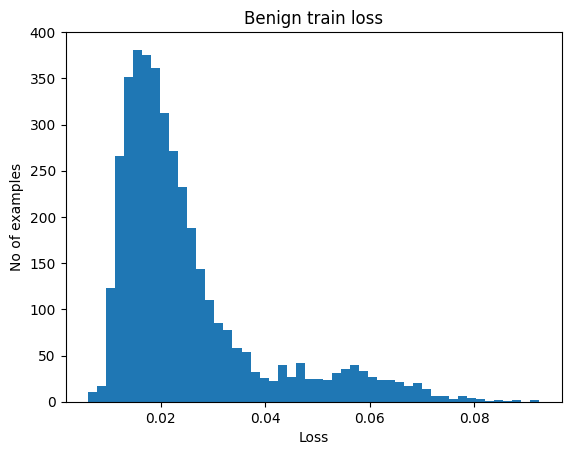

Train loss span:  [0.01096075214445591-0.03928007185459137]
Benign train threshold:  0.03928007
(4000, 4, 120, 120)
(4000, 4, 120, 120)


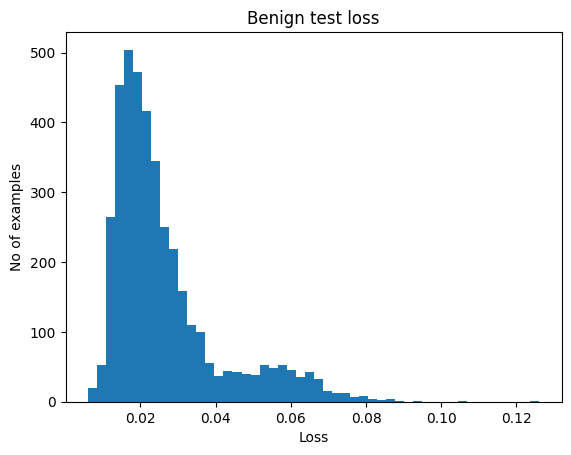

Benign test loss span:  [0.011855385266244411-0.04101887717843056]
(3367, 4, 120, 120)
(3367, 4, 120, 120)


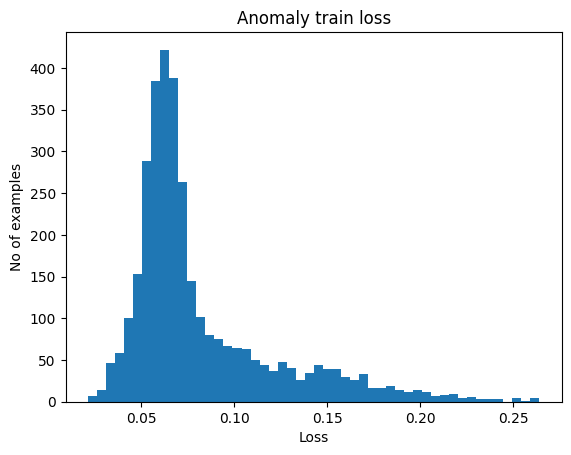

benign train-test, anomalous-train span:  [0.01096075214445591-0.03928007185459137] [0.011855385266244411-0.04101887717843056] [0.042432572692632675-0.12247705459594727]
Anomaly train threshold:  0.042432573


In [26]:
recalculate_thresholds()

Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

Classify an samples as an anomaly if the reconstruction error is greater than the threshold.

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def predict(model, data, threshold):
    loss = calculate_loss(model, data)
    return tf.math.less(loss, threshold)


# cannot memoize without threshold with the following memoize function
def get_stats(predictions, labels):
    return f"Accuracy = {accuracy_score(labels, predictions)}"


def get_stats_all(predictions, labels):
    return f"""{get_stats(predictions, labels)}
Precision = {precision_score(labels, predictions)}
Recall = {recall_score(labels, predictions)}
F1 = {f1_score(labels, predictions)}
confusion_matrix -\n{confusion_matrix(labels, predictions)}
"""

In [28]:
from itertools import repeat, chain


def evaluate(model, threshold):
    output = f"\n[*] Calculating result with threshold {threshold}"
    predications_benign = predict(model, test_batch, threshold)
    labels_benign = list(repeat(True, len(predications_benign)))
    stats_benign = get_stats(predications_benign, labels_benign)
    output += "\n~ Benign test performance ~\n" + stats_benign

    predications_anomaly = predict(model, anomaly_train_batch, threshold)
    labels_anomaly = list(repeat(False, len(predications_anomaly)))
    stats_anomaly = get_stats(predications_anomaly, labels_anomaly)
    output += "\n~ Anomaly train performance ~\n" + stats_anomaly

    predications_anomaly_test = predict(model, anomaly_test_batch, threshold)
    labels_anomaly_test = list(repeat(False, len(predications_anomaly_test)))
    stats_anomaly = get_stats(predications_anomaly_test, labels_anomaly_test)
    output += "\n~ Anomaly test performance ~\n" + stats_anomaly

    predications_total = list(chain(predications_benign, predications_anomaly, predications_anomaly_test))
    labels_total = list(chain(labels_benign, labels_anomaly, labels_anomaly_test))
    stats_total = get_stats_all(predications_total, labels_total)
    output += "\nTotal performance: \n" + stats_total
    return output

In [29]:
# print(evaluate(autoencoder, threshold))
print(evaluate(autoencoder, anomaly_threshold))

(4000, 4, 120, 120)
(4000, 4, 120, 120)
(3367, 4, 120, 120)
(3367, 4, 120, 120)
(1443, 4, 120, 120)
(1443, 4, 120, 120)

[*] Calculating result with threshold 0.042432572692632675
~ Benign test performance ~
Accuracy = 0.865
~ Anomaly train performance ~
Accuracy = 0.9536679536679536
~ Anomaly test performance ~
Accuracy = 0.954954954954955
Total performance: 
Accuracy = 0.9136208853575483
Precision = 0.9399619668568324
Recall = 0.865
F1 = 0.9009243588074469
confusion_matrix -
[[4589  221]
 [ 540 3460]]



In [30]:
def log_results(file_name: str):
    with open(OUTPUT_FILE.format(file_name=file_name, file_type='log'), 'w+') as f:
        date = datetime.datetime.now().strftime("%d/%m/%y %H:%M")
        f.write(f"Date: {date}\n")
        f.write(f"Sample length seconds: {SAMPLE_LENGTH_SECONDS}\n")
        f.write(f"Sample per second: {DATAPOINTS_PER_SECOND}\n")
        f.write(f"Resample: {RESAMPLE_MS}\n")
        f.write(f"INPUT_SHAPE: {INPUT_SHAPE}\n")

        f.write("\n\n!! Model Info !!\n")
        sub_autoencoder = autoencoder._auto_encoders[0]
        f.write(f"ENCODED_SIZE\n: {sub_autoencoder.ENCODED_SIZE}")
        f.write(f"Encoder:\n")
        sub_autoencoder.encoder.summary(print_fn=lambda x: f.write(x + '\n'))
        f.write(f"Decoder:\n")
        sub_autoencoder.decoder.summary(print_fn=lambda x: f.write(x + '\n'))

        f.write("\n\n!! Dataset Info !!\n")
        f.write(f"Sensor: {sensor}\n")
        f.write(f"Train: <data: {len(train_dataset.get_train())}>, Test:<data: {len(train_dataset.get_test())}>\n")
        f.write(
            f"Anomalies: <data: {len(anomaly_dataset.get_train())}>, Test:<data: {len(anomaly_dataset.get_test())}>\n")
        f.write(f"Benign train span: {benign_train_span}\n")
        f.write(f"Benign test span: {benign_test_span}\n")
        f.write(f"Anomaly train span: {anomaly_train_span}\n")

        f.write("\n\n!! First evaluation !!\n")
        f.write(evaluate(autoencoder, threshold))
        f.write("\n\n!! Second evaluation !!\n")
        f.write(evaluate(autoencoder, anomaly_threshold))

In [31]:
if autoencoder.new_model:
    save_model()
    log_results("_".join(AXES) + "_" + get_model_file_name())

Saving model <__main__.AnomalyDetector object at 0x7f6c5c3a67a0> to models/gaf_autoencoders/RawExtractor/23.08.05/10.00//gyroscope_500msx4_(120, 120)_300*.h5
Saving model <__main__.AnomalyDetector object at 0x7f6c5c3b6dd0> to models/gaf_autoencoders/RawExtractor/23.08.05/10.00//gyroscope_500msx4_(120, 120)_300*.h5
Saving model <__main__.AnomalyDetector object at 0x7f6baf177fd0> to models/gaf_autoencoders/RawExtractor/23.08.05/10.00//gyroscope_500msx4_(120, 120)_300*.h5
Saving model <__main__.AnomalyDetector object at 0x7f6c5c363f10> to models/gaf_autoencoders/RawExtractor/23.08.05/10.00//gyroscope_500msx4_(120, 120)_300*.h5
(4000, 4, 120, 120)
(4000, 4, 120, 120)
(3367, 4, 120, 120)
(3367, 4, 120, 120)
(1443, 4, 120, 120)
(1443, 4, 120, 120)
(4000, 4, 120, 120)
(4000, 4, 120, 120)
(3367, 4, 120, 120)
(3367, 4, 120, 120)
(1443, 4, 120, 120)
(1443, 4, 120, 120)


In [32]:
def set_axes(axes, start_index, end_index):
    global autoencoder, train_dataset, anomaly_dataset
    autoencoder._axes = axes 
    autoencoder._auto_encoders_amount = end_index 
    autoencoder._start_index = start_index 
    train_dataset._axes = axes
    anomaly_dataset._axes = axes

In [33]:
# AXES = ['x', 'y', 'z', 'tot']
# set_axes(AXES, 0, len(AXES))

(4000, 4, 120, 120)
(4000, 3, 120, 120)


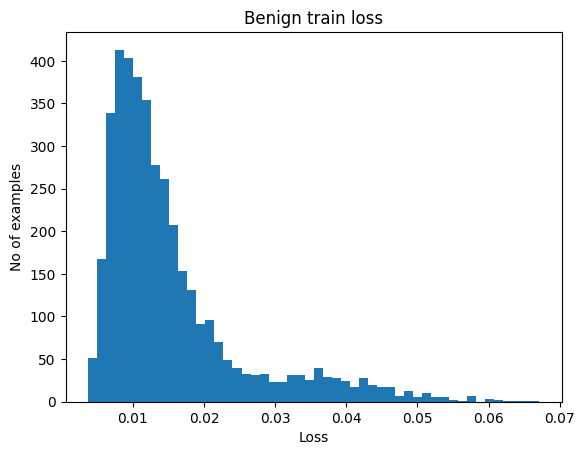

Train loss span:  [0.0053846267983317375-0.025361385196447372]
Benign train threshold:  0.025361385
(4000, 4, 120, 120)
(4000, 3, 120, 120)


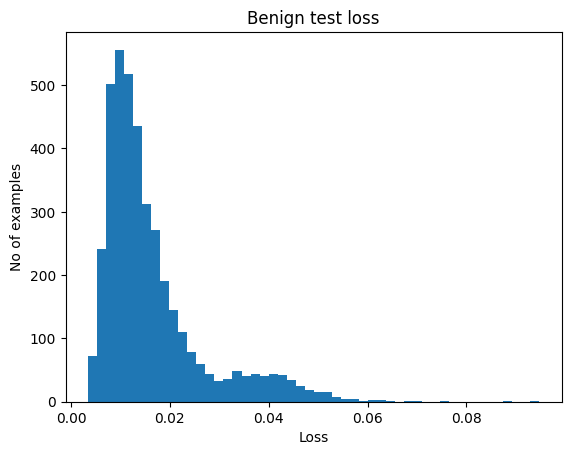

Benign test loss span:  [0.005888715386390686-0.026826325803995132]
(3367, 4, 120, 120)
(3367, 3, 120, 120)


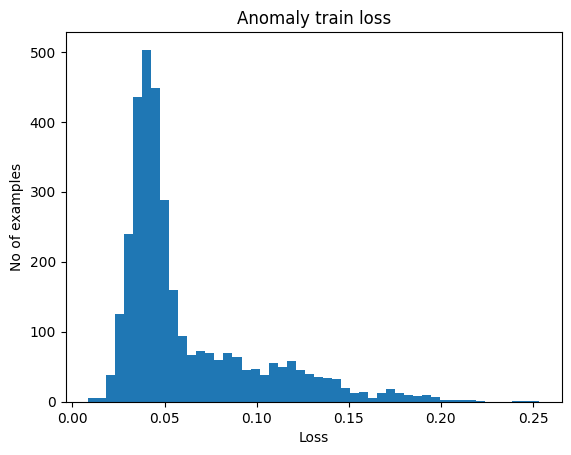

benign train-test, anomalous-train span:  [0.0053846267983317375-0.025361385196447372] [0.005888715386390686-0.026826325803995132] [0.02422231435775757-0.09965784102678299]
Anomaly train threshold:  0.024222314
(4000, 4, 120, 120)
(4000, 3, 120, 120)
(3367, 4, 120, 120)
(3367, 3, 120, 120)
(1443, 4, 120, 120)
(1443, 3, 120, 120)
(4000, 4, 120, 120)
(4000, 3, 120, 120)
(3367, 4, 120, 120)
(3367, 3, 120, 120)
(1443, 4, 120, 120)
(1443, 3, 120, 120)


In [34]:
AXES = ['x', 'y', 'z']
set_axes(AXES, 0, len(AXES))
recalculate_thresholds()
log_results("_".join(AXES) + "_" + get_model_file_name())

(4000, 4, 120, 120)
(4000, 1, 120, 120)


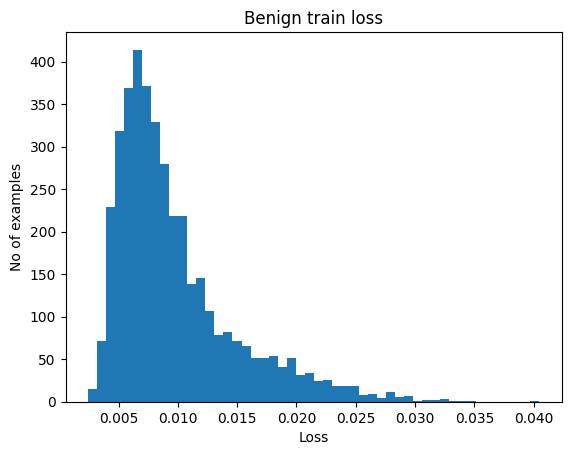

Train loss span:  [0.004653477109968662-0.01484133955091238]
Benign train threshold:  0.01484134
(4000, 4, 120, 120)
(4000, 1, 120, 120)


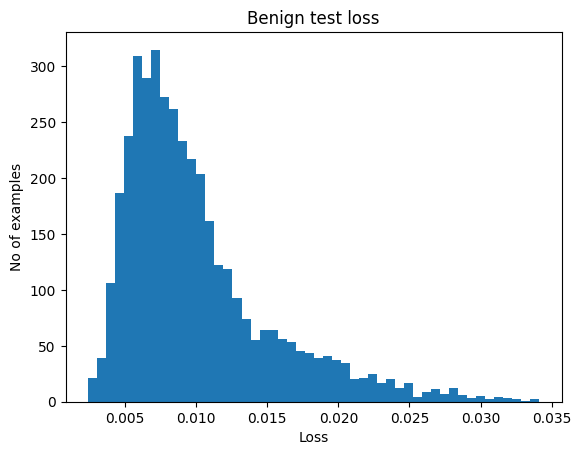

Benign test loss span:  [0.004897131118923426-0.015262091532349586]
(3367, 4, 120, 120)
(3367, 1, 120, 120)


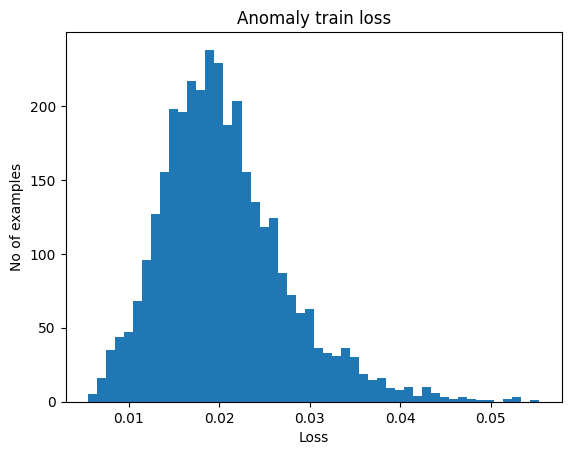

benign train-test, anomalous-train span:  [0.004653477109968662-0.01484133955091238] [0.004897131118923426-0.015262091532349586] [0.013575559481978416-0.027453916147351265]
Anomaly train threshold:  0.0135755595
(4000, 4, 120, 120)
(4000, 1, 120, 120)
(3367, 4, 120, 120)
(3367, 1, 120, 120)
(1443, 4, 120, 120)
(1443, 1, 120, 120)
(4000, 4, 120, 120)
(4000, 1, 120, 120)
(3367, 4, 120, 120)
(3367, 1, 120, 120)
(1443, 4, 120, 120)
(1443, 1, 120, 120)


In [35]:
AXES = ['tot']
set_axes(AXES, 3, 4)
recalculate_thresholds()
log_results("_".join(AXES) + "_" + get_model_file_name())

In [ ]:
# wait for autosave
import time
time.sleep(180)

In [ ]:
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)